# **Gaussian Naive Bayesian algorithm**
<img src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FO8UC8%2FbtqTF4pek3e%2Fhm2143D75Ll7WBLBAlWJE1%2Fimg.png'>
---



<img src='https://mblogthumb-phinf.pstatic.net/20160622_22/alwaysneoi_1466583096349iiYdV_PNG/%C1%B6%B0%C7%BA%CE_%C8%AE%B7%FC.png?type=w2'>

>> **<font color='blue'>사후확률을 직접 구하기는 힘들지만 데이터의 분포에서 사전확률과 우도를 구하면 사후확률을 쉽게 구할 수 있다.**
<img src = 'https://miro.medium.com/max/1313/1*lx--GFnyowNVBLOXrkPuaQ.png' width=600>

<img src='https://miro.medium.com/max/1313/1*_DyCqF1TdNdlqI4v-MHEfQ.gif'>

#### **사실과 증거가 쌓이면 나의 믿음은 변한다.**
>>> <img src='https://miro.medium.com/max/797/1*atTatWle6TzK7l7q1EDz9Q.jpeg'>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline, make_pipeline

# 모델저장
from joblib import dump, load

## **[1. Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) 사이트의 데이터를 바탕으로 이해해보자**

In [1]:
import requests
from bs4 import BeautifulSoup

# 웹 페이지 URL
url = 'https://en.wikipedia.org/wiki/Naive_Bayes_classifier'

# 웹 페이지 내용을 가져옵니다.
response = requests.get(url)
html = response.text

# BeautifulSoup을 사용하여 HTML 파싱
soup = BeautifulSoup(html, 'html.parser')

# 원하는 테이블을 선택합니다.
# 예를 들어, 첫 번째 테이블을 선택하려면 다음과 같이 합니다.
table = soup.find('table', class_='wikitable')

# 테이블의 행을 반복하여 데이터 추출
for row in table.find_all('tr'):
    # 각 행의 열을 추출
    columns = row.find_all('td')
    if columns:  # 빈 행을 건너뜁니다.
        person = columns[0].get_text()
        height = columns[1].get_text()
        weight = columns[2].get_text()
        foot_size = columns[3].get_text()

        # 여기에서 데이터를 처리하거나 출력합니다.
        print(f"Person: {person}, Height: {height}, Weight: {weight}, Foot Size: {foot_size}")

Person: male, Height: 6, Weight: 180, Foot Size: 12

Person: male, Height: 5.92 (5'11"), Weight: 190, Foot Size: 11

Person: male, Height: 5.58 (5'7"), Weight: 170, Foot Size: 12

Person: male, Height: 5.92 (5'11"), Weight: 165, Foot Size: 10

Person: female, Height: 5, Weight: 100, Foot Size: 6

Person: female, Height: 5.5 (5'6"), Weight: 150, Foot Size: 8

Person: female, Height: 5.42 (5'5"), Weight: 130, Foot Size: 7

Person: female, Height: 5.75 (5'9"), Weight: 150, Foot Size: 9



In [2]:
import pandas as pd
# 테이블을 데이터프레임으로 변환
df = pd.read_html(str(table))[0]

# 데이터프레임 출력
df

,Person,height (feet),weight (lbs),foot size(inches)
0,male,6,180,12
1,male,"5.92 (5'11"")",190,11
2,male,"5.58 (5'7"")",170,12
3,male,"5.92 (5'11"")",165,10
4,female,5,100,6
5,female,"5.5 (5'6"")",150,8
6,female,"5.42 (5'5"")",130,7
7,female,"5.75 (5'9"")",150,9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Person             8 non-null      object
 1   height (feet)      8 non-null      object
 2   weight (lbs)       8 non-null      int64 
 3   foot size(inches)  8 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 384.0+ bytes


In [4]:
df['height (feet)'].str.split('(')

0                [6]
1    [5.92 , 5'11")]
2     [5.58 , 5'7")]
3    [5.92 , 5'11")]
4                [5]
5      [5.5 , 5'6")]
6     [5.42 , 5'5")]
7     [5.75 , 5'9")]
Name: height (feet), dtype: object

In [5]:
df['height (feet)'] = df['height (feet)'].apply(lambda x : float(x.split('(')[0]))

<Axes: xlabel='height (feet)', ylabel='Person'>

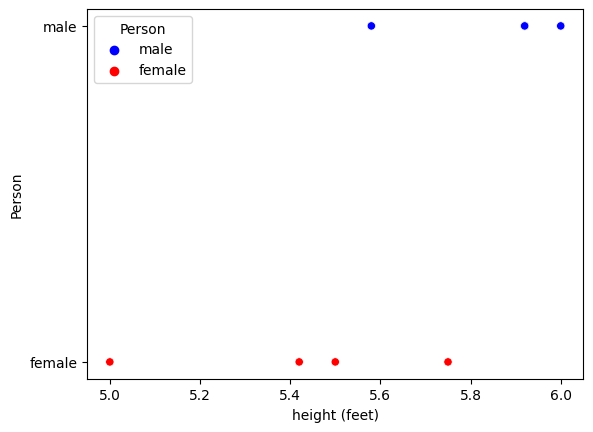

In [6]:
import seaborn as sns
# Seaborn을 사용하여 시각화
sns.scatterplot(x='height (feet)', y='Person', data=df, hue='Person', palette={'male': 'blue', 'female': 'red'}, marker='o')

<Axes: xlabel='height (feet)', ylabel='Person'>

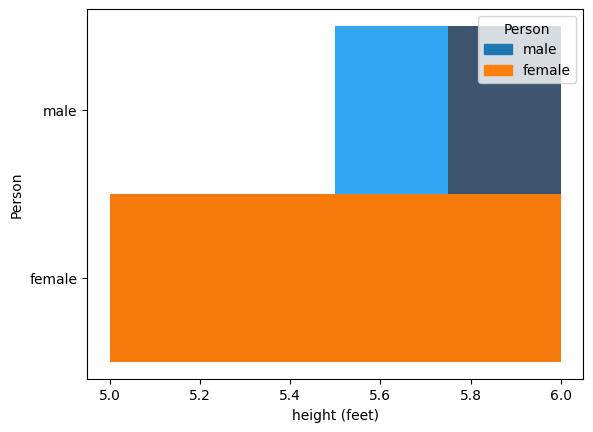

In [7]:
sns.histplot(x='height (feet)', y='Person', data=df, hue='Person')

<ipython-input-8-aa0b166c2bbb>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Person'] == 'male']['height (feet)'], label='Male', color='blue', shade=True)
<ipython-input-8-aa0b166c2bbb>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Person'] == 'female']['height (feet)'], label='Female', color='red', shade=True)


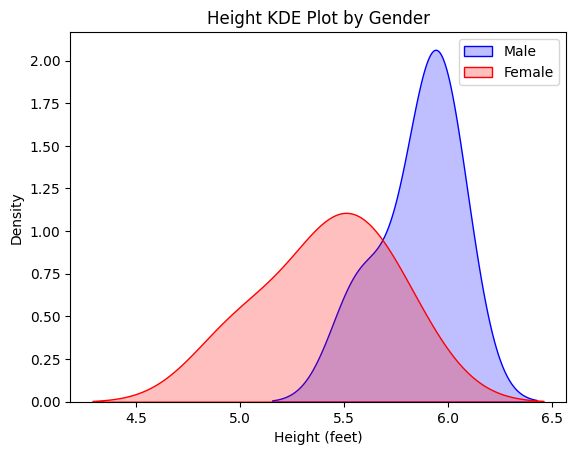

In [8]:
import matplotlib.pyplot as plt

sns.kdeplot(data=df[df['Person'] == 'male']['height (feet)'], label='Male', color='blue', shade=True)
sns.kdeplot(data=df[df['Person'] == 'female']['height (feet)'], label='Female', color='red', shade=True)
plt.title('Height KDE Plot by Gender')
plt.xlabel('Height (feet)')
plt.ylabel('Density')
plt.legend()

plt.show()

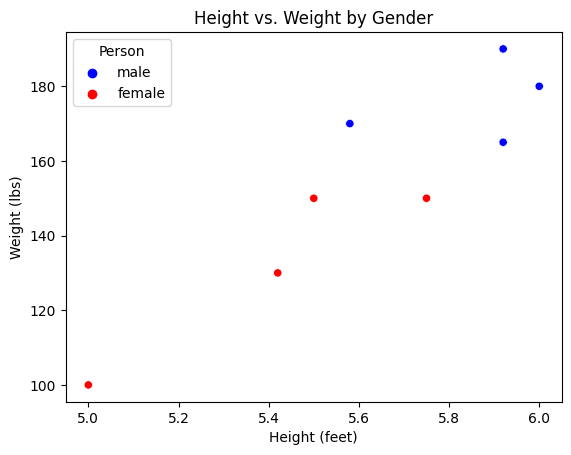

In [9]:
sns.scatterplot(data=df, x='height (feet)', y='weight (lbs)', hue='Person', palette={'male': 'blue', 'female': 'red'}, marker='o')

plt.title('Height vs. Weight by Gender')
plt.xlabel('Height (feet)')
plt.ylabel('Weight (lbs)')

plt.show()

In [10]:
df.head()

,Person,height (feet),weight (lbs),foot size(inches)
0,male,6.00,180,12
1,male,5.92,190,11
2,male,5.58,170,12
3,male,5.92,165,10
4,female,5.00,100,6


<ipython-input-11-398f992535f2>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df['height (feet)'], y=df['weight (lbs)'], cmap="Reds", shade=True, bw_adjust=.5)


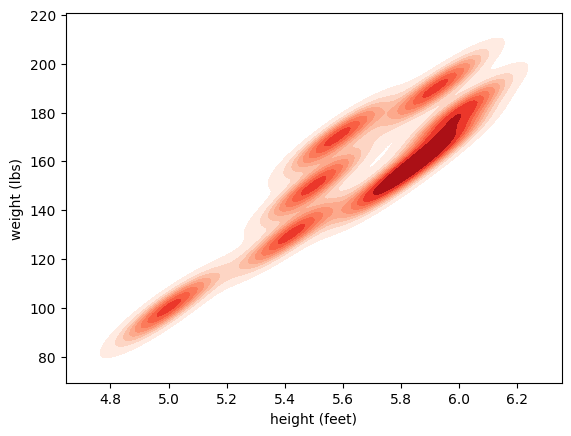

In [11]:
# Custom the color, add shade and bandwidth
sns.kdeplot(x=df['height (feet)'], y=df['weight (lbs)'], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

<ipython-input-15-afa6de39c80d>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df['height (feet)'], y=df['weight (lbs)'],


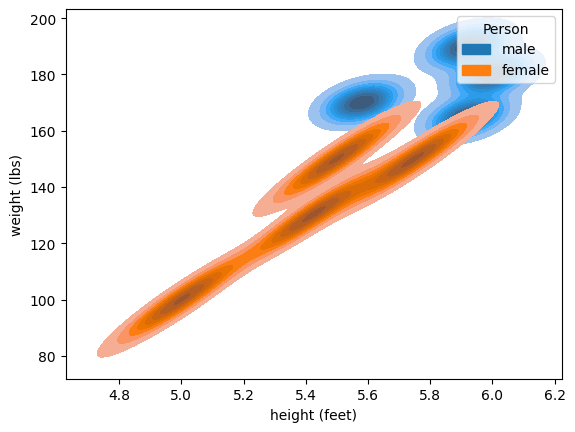

In [15]:
# Custom the color, add shade and bandwidth
sns.kdeplot(x=df['height (feet)'], y=df['weight (lbs)'],
            hue = df['Person'],
            shade=True, bw_adjust=.5)
plt.show()

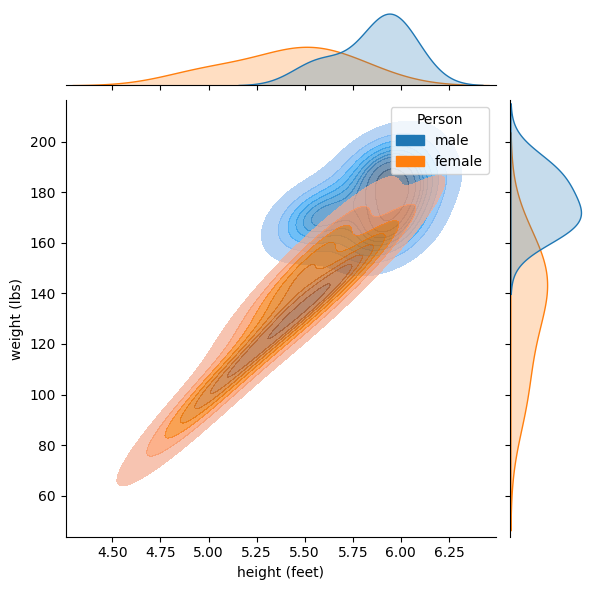

In [16]:
sns.jointplot(x=df['height (feet)'], y=df['weight (lbs)'],
              hue = df['Person'],
              kind='kde',
              fill=True,joint_kws={'alpha': 0.7})

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


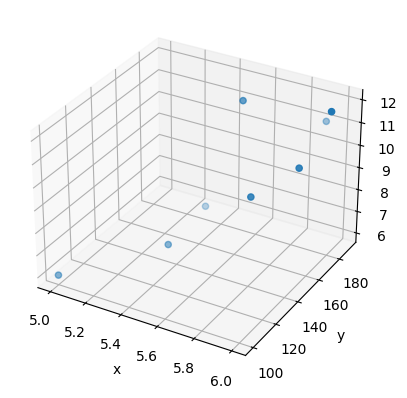

In [26]:
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(df['height (feet)'],
               df['weight (lbs)'],
               df['foot size(inches)'])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


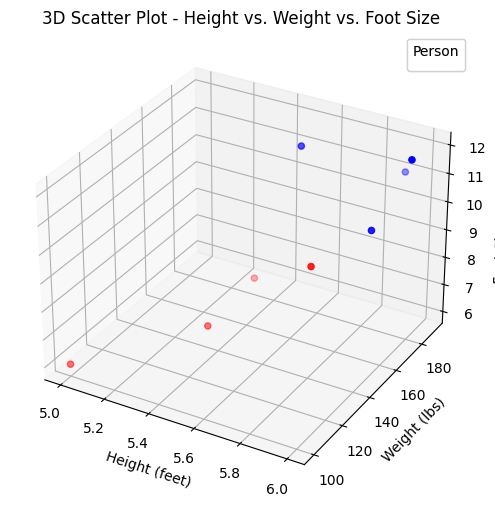

In [27]:
from mpl_toolkits.mplot3d import Axes3D

# 3D 그래프 생성
fig = plt.figure(figsize=(12, 6))
axes = fig.add_subplot(111, projection='3d')

# 남성과 여성 데이터를 색상으로 구분하여 표시
scatter = axes.scatter3D(df['height (feet)'], df['weight (lbs)'], df['foot size(inches)'],
                         c=df['Person'].map({'male': 'blue', 'female': 'red'}), label=df['Person'])

axes.set_title('3D Scatter Plot - Height vs. Weight vs. Foot Size')
axes.set_xlabel('Height (feet)')
axes.set_ylabel('Weight (lbs)')
axes.set_zlabel('Foot Size (inches)')

# 범례 추가
handles, labels = scatter.legend_elements()
legend = axes.legend(handles, labels, title='Person', loc='upper right')
axes.add_artist(legend)

plt.show()

- **[Naive Bayes 알고리즘](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)으로 예측모델 만들기**

In [36]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

gnb = GaussianNB()

y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 75 points : 4


In [40]:
df

,Person,height (feet),weight (lbs),foot size(inches)
0,male,6.00,180,12
1,male,5.92,190,11
2,male,5.58,170,12
3,male,5.92,165,10
4,female,5.00,100,6
5,female,5.50,150,8
6,female,5.42,130,7
7,female,5.75,150,9


In [41]:
X = df.drop(columns=['Person'])
y = df['Person'].apply(lambda x: 1 if x == 'male' else 0)

In [43]:
gnb.fit(X, y)
gnb.predict(X)

array([1, 1, 1, 1, 0, 0, 0, 0])

- **모델 확인 및 새로운 데이터(6, 130, 8)의 성별을 예측**

In [45]:
gnb

GaussianNB()

In [46]:
gnb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [51]:
# 새로운 데이터의 성별 예측
gnb.predict([[6, 130, 8]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


array([0])

In [52]:
# 새로운 데이터의 성별 예측 확률
gnb.predict_proba([[6, 130, 8]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


array([[9.99999846e-01, 1.54426632e-07]])

#### **가상 데이터를 생성하여(Generative AI) 데이터를 시각화해보고 생성형 AI알고리즘을 이해하자**

In [29]:
df

,Person,height (feet),weight (lbs),foot size(inches)
0,male,6.00,180,12
1,male,5.92,190,11
2,male,5.58,170,12
3,male,5.92,165,10
4,female,5.00,100,6
5,female,5.50,150,8
6,female,5.42,130,7
7,female,5.75,150,9


In [30]:
df.describe()

,height (feet),weight (lbs),foot size(inches)
count,8.000000,8.000000,8.000000
mean,5.636250,154.375000,9.375000
std,0.333721,28.962722,2.263846
min,5.000000,100.000000,6.000000
25%,5.480000,145.000000,7.750000
50%,5.665000,157.500000,9.500000
75%,5.920000,172.500000,11.250000
max,6.000000,190.000000,12.000000


- **각 변수의 평균과 분산으로 가상데이터(1000개)를 생성(Generate)해보자**

In [53]:
import numpy as np

number = 10000  # 가상 데이터 sample size

feet = np.random.normal(df['height (feet)'].mean(), df['height (feet)'].std(), size=number)
lbs = np.random.normal(df['weight (lbs)'].mean(), df['weight (lbs)'].std(), size=number)
inches = np.random.normal(df['foot size(inches)'].mean(), df['foot size(inches)'].std(), size=number)

In [62]:
gpt = pd.DataFrame({'Height' : feet, 'Weight' : lbs, 'Foot' : inches})
gpt.head()

,Height,Weight,Foot
0,5.662798,147.390361,7.205772
1,5.697218,95.422461,11.907594
2,5.756851,180.496415,7.732945
3,5.590732,165.425288,10.011871
4,5.269997,127.689163,8.961814


In [64]:
gnb

GaussianNB()

In [63]:
gnb.predict(gpt)

ValueError: ignored

In [66]:
gpt = pd.DataFrame({'height (feet)' : feet, 'weight (lbs)' : lbs, 'foot size(inches)' : inches})
gpt.head()

,height (feet),weight (lbs),foot size(inches)
0,5.662798,147.390361,7.205772
1,5.697218,95.422461,11.907594
2,5.756851,180.496415,7.732945
3,5.590732,165.425288,10.011871
4,5.269997,127.689163,8.961814


In [67]:
gnb.predict(gpt)

array([0, 0, 0, ..., 0, 1, 0])

In [69]:
gpt['gender'] = gnb.predict(gpt)
gpt['gender'] = gpt['gender'].map({0: 'male', 1: 'female'})

In [70]:
gpt

,height (feet),weight (lbs),foot size(inches),gender
0,5.662798,147.390361,7.205772,male
1,5.697218,95.422461,11.907594,male
2,5.756851,180.496415,7.732945,male
3,5.590732,165.425288,10.011871,female
4,5.269997,127.689163,8.961814,male
...,...,...,...,...
9995,5.250921,144.734662,6.343687,male
9996,6.241883,118.068447,10.726971,male
9997,6.221790,128.597431,9.538226,male
9998,5.344117,165.454161,11.295665,female


In [71]:
gpt.columns

Index(['height (feet)', 'weight (lbs)', 'foot size(inches)', 'gender'], dtype='object')

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


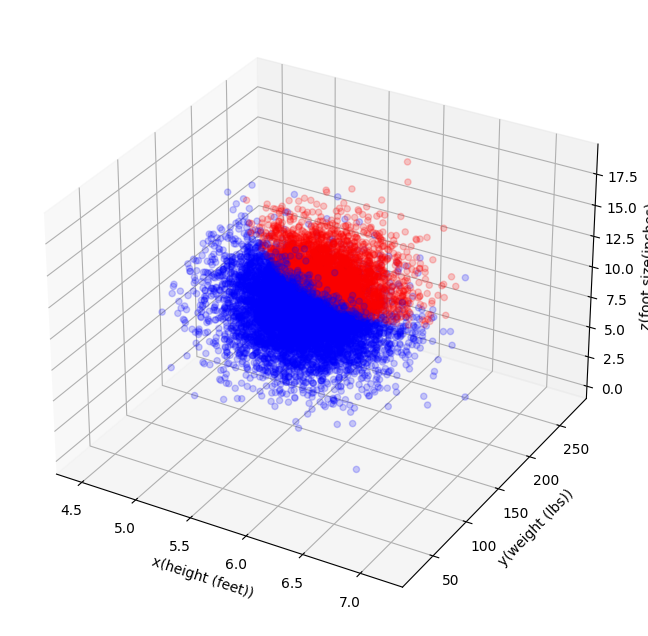

In [81]:
plt.figure(figsize=(15,8))
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(gpt['height (feet)'],
               gpt['weight (lbs)'],
               gpt['foot size(inches)'],
               c=gpt['gender'].map({'male': 'blue', 'female': 'red'}),
               alpha = 0.2
               )

axes.set_xlabel('x(height (feet))')
axes.set_ylabel('y(weight (lbs))')
axes.set_zlabel('z(foot size(inches)')
plt.show()

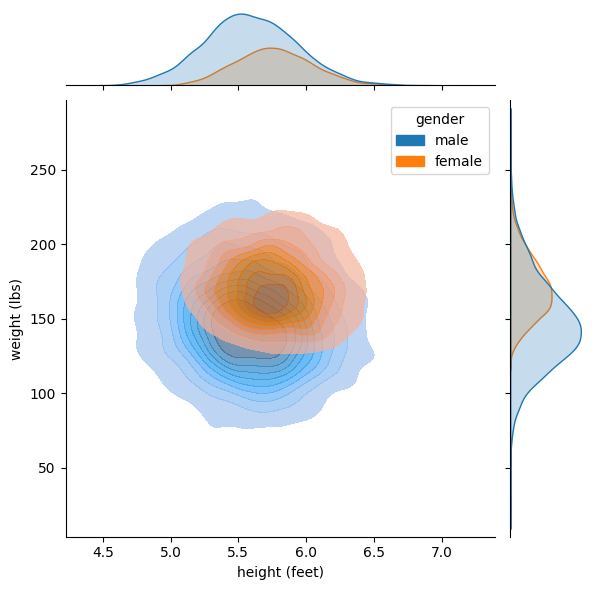

In [80]:
sns.jointplot(x=gpt['height (feet)'], y=gpt['weight (lbs)'],
              hue = gpt['gender'],
              kind='kde',
              fill=True,joint_kws={'alpha': 0.7})

## **2. Probability density function이 우도(likelihood)**
>> **우도란 그럴 듯한 정도, 즉 확률변수가 특정 값을 보일 확률(그럴 듯함)**


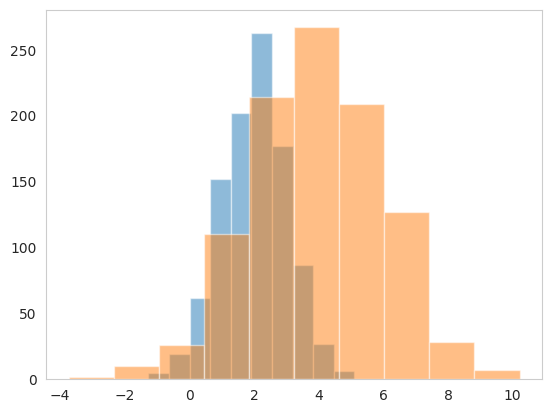

In [84]:
sns.set_style("whitegrid", {'axes.grid' : False})
# 평균과 분산이 각각 2,1
mu_A, sigma_A = 2, 1
ax = plt.hist(np.random.normal(mu_A, sigma_A, size=(1000)), alpha=0.5)

# 평균과 분산이 각각 4,2
mu_B, sigma_B = 4, 2
ax = plt.hist(np.random.normal(mu_B, sigma_B, size=(1000)), alpha=0.5)

#### **X가 '2'일 경우 두 집단 사이에 어디에 속할 것 같니? 어디가 그럴 듯한가?**

In [ ]:
import scipy
scipy.stats.norm(mu_A, sigma_A).pdf(2) # '2'를 관측하였을 경우 A분포의 우도
print('\n')
scipy.stats.norm(mu_B, sigma_B).pdf(2) # '2'를 관측하였을 경우 B분포의 우도

0.3989422804014327

0.12098536225957168

## **3. Gaussian Naive Bayes**
>> #### **확률변수의 분포가 정규분포, 가우신안 분포를 가정한다**

<img src= 'https://wikimedia.org/api/rest_v1/media/math/render/svg/1eaed580cf7c29f044a9e517f1cd4a7dd69c4b1f'>

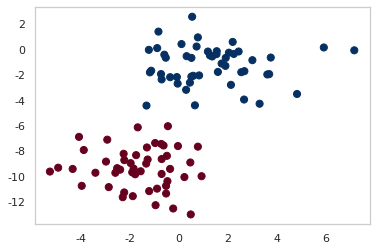

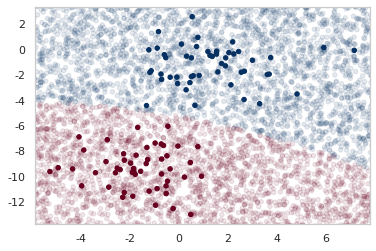

In [ ]:
from sklearn.datasets import make_blobs
plt.rcParams['axes.unicode_minus'] = False
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');plt.show()

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(5000, 2)
ynew= model.predict(Xnew)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

- 의사결정경계선이 곡선으로 나타나고 예측 확률은 '0', '1'에 편중하여 생성

Text(0.5, 1.0, 'Naive Bayes Model')

[(-15.0, 5.0), (-8.0, 8.0)]

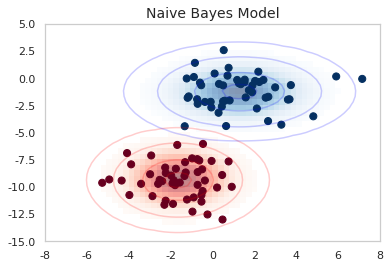

In [ ]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)

ax.set(xlim=xlim, ylim=ylim)

(array([2086.,   66.,   37.,   35.,   42.,   32.,   44.,   43.,   66.,
        2549.]),
 array([3.0043337e-16, 1.0000000e-01, 2.0000000e-01, 3.0000000e-01,
        4.0000000e-01, 5.0000000e-01, 6.0000000e-01, 7.0000000e-01,
        8.0000000e-01, 9.0000000e-01, 1.0000000e+00]),
 <a list of 10 Patch objects>)

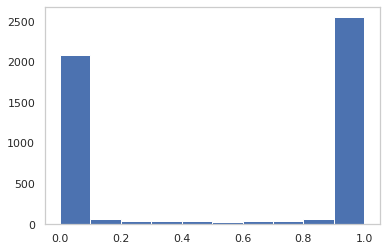

In [ ]:
yprob = model.predict_proba(Xnew)
plt.hist(yprob[:, 1])

베이지안 이론에서 확률이란 관측된 사실(데이터)에 따라 변화되는 신념(credibility)

## **4. Text mining with GNB, scikit-learn API**

In [ ]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
corpus
df = pd.DataFrame(corpus, columns=['content'])
df

['This is the first document.',
 'This document is the second document.',
 'And this is the third one.',
 'Is this the first document?']

,content
0,This is the first document.
1,This document is the second document.
2,And this is the third one.
3,Is this the first document?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus) # X = vectorizer.fit_transform(df['content'])
print(vectorizer.get_feature_names())
print(X.toarray())

data = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
data

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,2,0,1,0,1,1,0,1
2,1,0,0,1,1,0,1,1,1
3,0,1,1,1,0,0,1,0,1


TF–IDF
- CountVectorizer 방식의 단점은 너무 자주 나오는 단어에 가중치가 높아져 sub-optimal in some classification algorithms.
- 이러한 점을 보완하기 위해 *term frequency-inverse document frequency* (*TF–IDF*)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(corpus)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,and,document,first,is,one,second,the,third,this
0,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085
1,0.000000,0.687624,0.000000,0.281089,0.000000,0.538648,0.281089,0.000000,0.281089
2,0.511849,0.000000,0.000000,0.267104,0.511849,0.000000,0.267104,0.511849,0.267104
3,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085


- 총 3개의 문서가 리스트형식으로 있다고 가정

In [ ]:
sample_kor = ['아버지가 가방에 들어가신다.', '어머니는 시장에 가신다', '붙여쓰면모르지']
vec = CountVectorizer()
X = vec.fit_transform(sample_kor)
X.toarray()
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

array([[1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 0]])

,가방에,가신다,들어가신다,붙여쓰면모르지,시장에,아버지가,어머니는
0,1,0,1,0,0,1,0
1,0,1,0,0,1,0,1
2,0,0,0,1,0,0,0


## **5. Multinomial Naive Bayes**
- **단어의 출현빈도가 특성변수와 관련**
- **20 Newsgroups corpus를 사용하여 3개의 그룹으로 분류하는 방법**

In [ ]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
data.keys()
df = pd.DataFrame(data['data'], columns= ['content'])
df['target'] = pd.Series(data.target)
convert = dict(zip(np.arange(len(data.target_names)), data.target_names, ))
df['categories'] = df['target'].map(convert)
df.head()
df.shape

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

,content,target,categories
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


(11314, 3)

In [ ]:
subset='train'

In [ ]:
from sklearn.model_selection import train_test_split
X, y = fetch_20newsgroups(return_X_y=True)
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(X, y, stratify=y)

- TF-IDF vectorizer와 multinomial naive Bayes classifier를 를 pipeline으로 구성
- 파이프라인을 데이터에 적용하여 예측하면
- test data의 레이블을 예측하고 실제 자료의 레이블과 confusion matrix를 확인하면

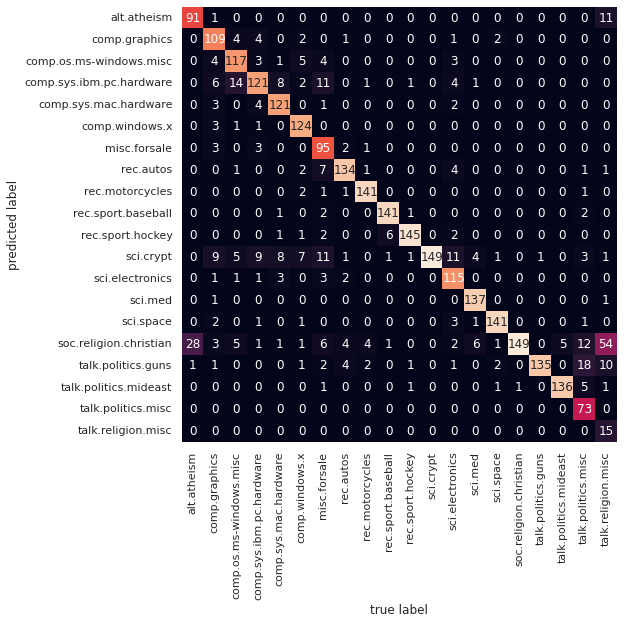

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(train_data, train_target)
labels = model.predict(test_data)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_target, labels)
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

<font color='red'> 각 단어의 빈도로 예측이 거의 완벽
- 새로운 값(text)를 예측해보자

In [ ]:
y_pred = model.predict(['I am a religious robot cop.'])
print(y_pred)
data.target_names
print('\n')
data.target_names[y_pred[0]]

[15]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

'soc.religion.christian'

In [ ]:
model.predict(['The Russian rocket agency is expected to',
               'Worship like a pop at the Shrine of Your Lies'])

array([14, 15])

In [ ]:
data.target_names[14]
data.target_names[15]

'sci.space'

'soc.religion.christian'

## **6. 데이터의 특성에 따라 예측을 잘하는 알고리즘이 있음**

<Figure size 576x432 with 0 Axes>

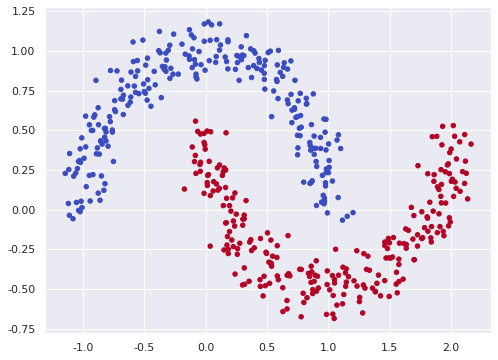

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
X, y = make_moons(n_samples=500, noise=0.1)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')

Text(0.5, 1.0, 'KNeighborsClassifier()')

Text(0.5, 1.0, 'GaussianNB()')

Text(0.5, 1.0, 'SGDClassifier()')

Text(0.5, 1.0, 'LogisticRegression()')

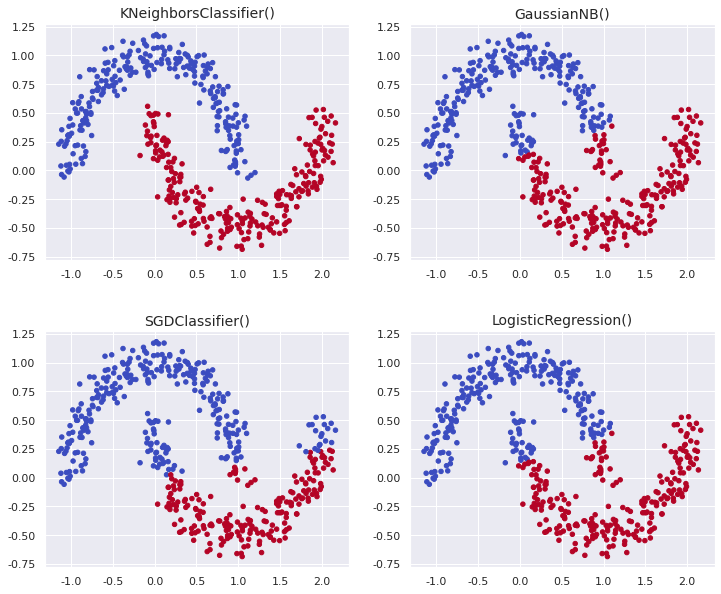

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression

fig, axs = plt.subplots(2,2, figsize=(12, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()
classifiers = [KNeighborsClassifier(), GaussianNB(),
               SGDClassifier(), LogisticRegression()]
for i, classifier in enumerate(classifiers) :
    axs[i].set_title(str(classifier), fontsize='14')
    y_pred = classifier.fit(X, y).predict(X)
    axs[i].scatter(X[:, 0], X[:, 1], c=y_pred, s=20, cmap='coolwarm')

# END